
# 3D Shape Deformation Analysis and Reconstruction

This Jupyter Notebook provides a step-by-step solution to analyze the deformations of a machine component,
determine its original shape, and reconstruct it by correcting the deformations.

## **Problem Overview**
A machine component was scanned, and its 3D shape was represented as a point cloud.
The objective is to:
1. Determine the original shape of the object.
2. Identify the deformations present in the component.
3. Reconstruct the original shape by correcting the deformations.

In [1]:
# ## Step 1: Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.optimize import leastsq


In [2]:
# ## Step 2: Load and Visualize the 3D Point Cloud Data

# Load point cloud data
file_path = "3d_shape_points_data.npz"
data = np.load(file_path)
points = data["points"]

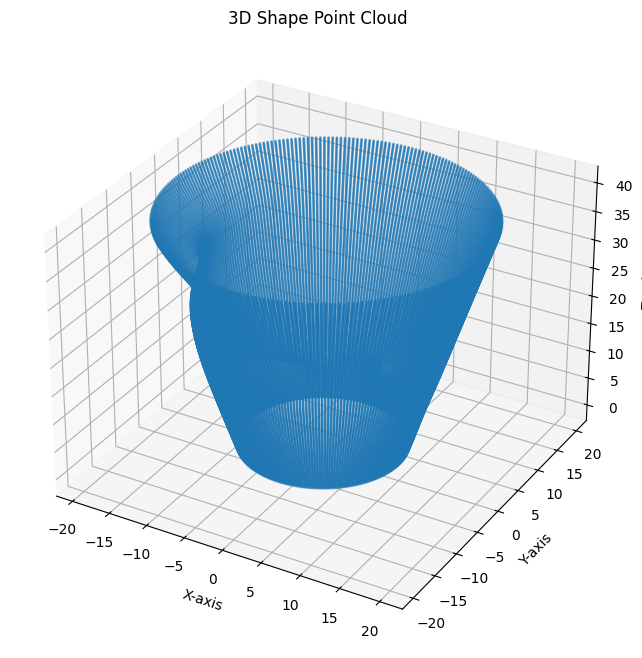

In [3]:
# Visualize the point cloud
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, alpha=0.5)
ax.set_title("3D Shape Point Cloud")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.show()

"""
## **Step 3: Determine the Original Shape using PCA**
Principal Component Analysis (PCA) helps in understanding the major directions of variation in the shape,
which can provide clues about the original structure before deformation.
"""

In [4]:
# Apply PCA
pca = PCA(n_components=3)
pca.fit(points)
center = np.mean(points, axis=0)
principal_axes = pca.components_


## **Step 4: Fit a Cylinder to the Point Cloud**
Since the PCA results suggest an elongated shape, we assume the original shape is a cylinder.
We estimate the cylinder’s axis and radius using least squares fitting.

In [5]:
# Function to project points onto a plane perpendicular to the cylinder axis
def project_onto_plane(points, axis_direction, point_on_axis):
    vectors = points - point_on_axis
    projections = vectors - np.outer(np.dot(vectors, axis_direction), axis_direction)
    return projections

axis_direction = principal_axes[0]
projected_points = project_onto_plane(points, axis_direction, center)
projected_distances = np.linalg.norm(projected_points, axis=1)
cylinder_radius = np.median(projected_distances)

def cylinder_residuals(params, points, axis_direction):
    x0, y0, r = params
    projected_points = project_onto_plane(points, axis_direction, np.array([x0, y0, 0]))
    distances = np.linalg.norm(projected_points, axis=1)
    return distances - r

initial_guess = [center[0], center[1], cylinder_radius]
optimized_params, _ = leastsq(cylinder_residuals, initial_guess, args=(points, axis_direction))
optimized_center = np.array([optimized_params[0], optimized_params[1], center[2]])
optimized_radius = optimized_params[2]

"""
## **Step 5: Identify Deformations**
Deformations are identified by measuring the deviation of each point from the estimated cylindrical surface.
"""

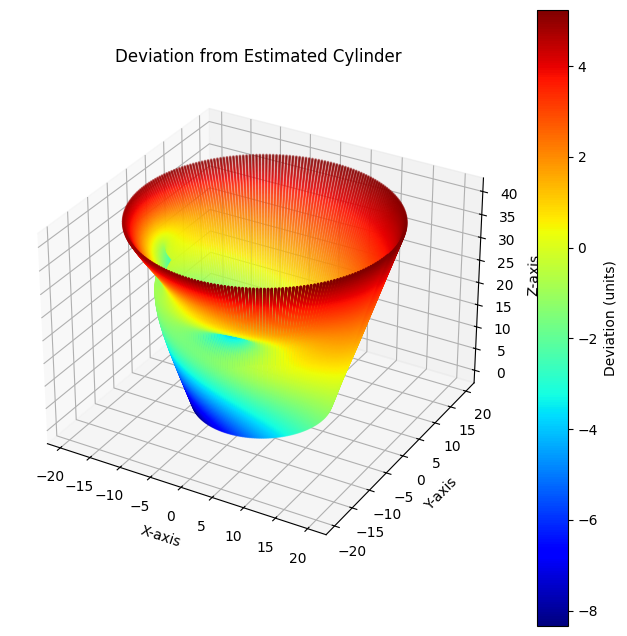

In [6]:
def compute_deviations(points, axis_direction, cylinder_center, cylinder_radius):
    projected_points = project_onto_plane(points, axis_direction, cylinder_center)
    distances = np.linalg.norm(projected_points, axis=1)
    deviations = distances - cylinder_radius
    return deviations

deviations = compute_deviations(points, axis_direction, optimized_center, optimized_radius)

# Visualizing the deviations
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=deviations, cmap="jet", s=1)
ax.set_title("Deviation from Estimated Cylinder")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.colorbar(sc, label="Deviation (units)")
plt.show()


"""
## **Step 6: Reconstruct the Original Shape**
The deformed points are corrected by projecting them onto the ideal cylindrical surface.
"""

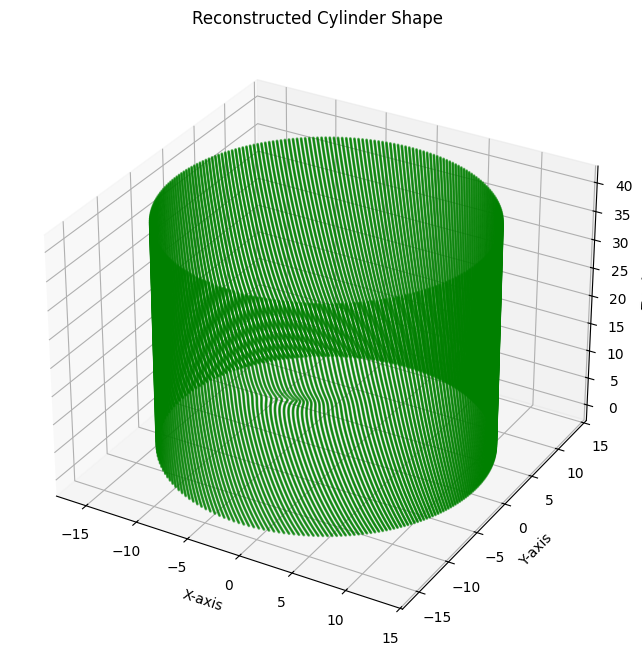

In [7]:
def reconstruct_cylinder(points, axis_direction, cylinder_center, cylinder_radius):
    projected_points = project_onto_plane(points, axis_direction, cylinder_center)
    distances = np.linalg.norm(projected_points, axis=1)
    scaling_factors = cylinder_radius / distances
    corrected_points = cylinder_center + scaling_factors[:, np.newaxis] * projected_points
    corrected_points[:, 2] = points[:, 2]
    return corrected_points

reconstructed_points = reconstruct_cylinder(points, axis_direction, optimized_center, optimized_radius)

# Visualizing the reconstructed shape
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reconstructed_points[:, 0], reconstructed_points[:, 1], reconstructed_points[:, 2], s=1, alpha=0.5, color='green')
ax.set_title("Reconstructed Cylinder Shape")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.show()


"""
## **Step 7: Save the Reconstructed Shape**
The final reconstructed point cloud is saved for submission.
"""

In [8]:
np.savez("reconstructed_shape.npz", points=reconstructed_points)


"""
## **Conclusion**
1. The original shape was identified as a **cylinder**.
2. Deformations were detected by computing deviations from the ideal cylindrical surface.
3. The shape was reconstructed by projecting the deformed points onto the ideal cylinder.

This step-by-step process successfully restored the original geometry.
"""